In [7]:
import contextily as ctx

In [8]:
import os
import geopandas as gpd
import scipy
from scipy.spatial import Delaunay

from matplotlib import pyplot
from matplotlib.pyplot import figure

%matplotlib inline

# Load `GeoJSON` data

In [9]:
path = './data/'
geo_df = gpd.read_file(os.path.join(path, 'los_angeles_censustracts.json'))
geo_df

MOVEMENT_ID   TRACT         DISPLAY_NAME  \
0              1  480302  Census Tract 480302   
1              2  480303  Census Tract 480303   
2              3  480304  Census Tract 480304   
3              4  480400  Census Tract 480400   
4              5  480500  Census Tract 480500   
...          ...     ...                  ...   
2711        2712  087902  Census Tract 087902   
2712        2713  110006  Census Tract 110006   
2713        2714  110007  Census Tract 110007   
2714        2715  110008  Census Tract 110008   
2715        2716  110604  Census Tract 110604   

                                               geometry  
0     POLYGON ((-118.11683 34.10722, -118.11631 34.1...  
1     POLYGON ((-118.13467 34.09877, -118.13464 34.0...  
2     POLYGON ((-118.13453 34.09157, -118.13462 34.0...  
3     POLYGON ((-118.12276 34.10447, -118.12386 34.1...  
4     POLYGON ((-118.14178 34.09877, -118.14178 34.0...  
...                                                 ...  
2711  POLYGON ((-117.98846 33.79567, -117.98806 33.7...  
2712  POLYGON ((-118.07218 33.79518, -118.07218 33.7...  
2713  POLYGON ((-118.08168 33.79407, -118.08155 33.7...  
2714  POLYGON ((-118.07618 33.78551, -118.07618 33.7...  
2715  POLYGON ((-117.99373 33.89540, -117.99221 33.8...  

[2716 rows x 4 columns]

# Calculate centroids of the polygons

In [10]:
centroid_series = geo_df.geometry.centroid
centroid_series

C:\Users\USER\anaconda3\envs\r\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.


0       POINT (-118.12180 34.10124)
1       POINT (-118.13772 34.09514)
2       POINT (-118.13160 34.09617)
3       POINT (-118.13217 34.10400)
4       POINT (-118.14534 34.09869)
                   ...             
2711    POINT (-117.98702 33.79190)
2712    POINT (-118.07791 33.79797)
2713    POINT (-118.08254 33.78830)
2714    POINT (-118.08009 33.78033)
2715    POINT (-117.99230 33.89361)
Length: 2716, dtype: geometry

In [11]:
import numpy as np
centroid_vec_series = centroid_series.apply(lambda p: np.array(p))
centroid_mat = np.stack(centroid_vec_series)
centroid_mat

array([[-118.12180209,   34.10124487],
       [-118.13771772,   34.09514198],
       [-118.13160206,   34.09616778],
       ...,
       [-118.0825363 ,   33.78830409],
       [-118.08008925,   33.78032972],
       [-117.99229601,   33.89361017]])

# Visualize

<AxesSubplot:>

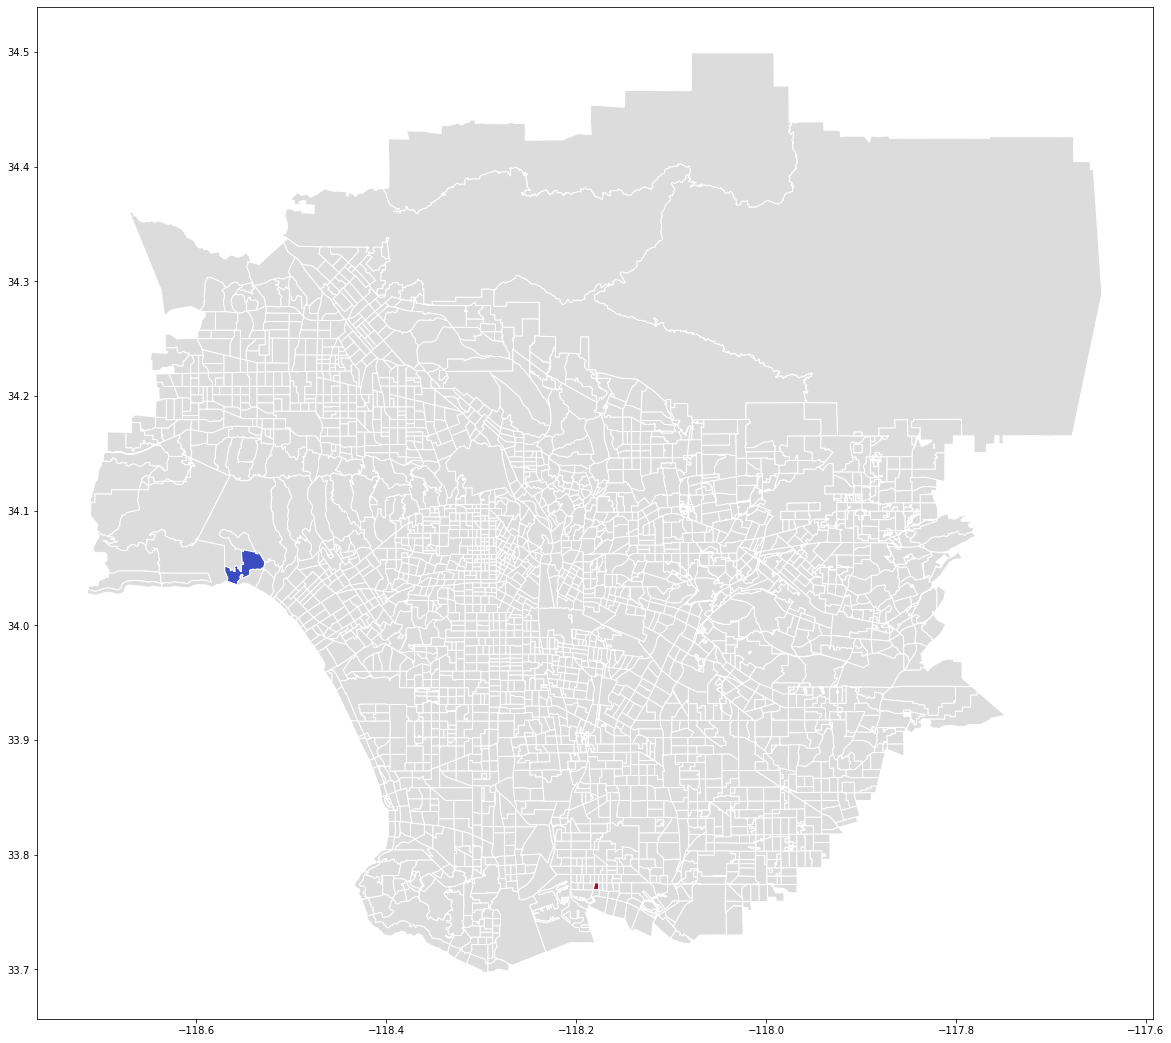

In [12]:
from shapely.geometry import Point
contain_long_beach = geo_df.geometry.contains(Point(-118.18, 33.77))
contain_malibu = geo_df.geometry.contains(Point(-118.56, 34.04))
# You may need to install additional packages (e.g. `geoplot`) to plot.
geo_df.plot(
    column=contain_long_beach + (-1)*contain_malibu,
    figsize=(20,20), categorical=True, cmap="coolwarm", edgecolor="white"
)

Load Uber data into a DataFrame

In [13]:
import networkx as nx
import pandas as pd
la = pd.read_csv(os.path.join(path, 'los_angeles-censustracts-2019-4-All-MonthlyAggregate.csv'))

Select for December

In [14]:
la_dec = la[la['month'] == 12]
print(la_dec.head())

   sourceid  dstid  month  mean_travel_time  standard_deviation_travel_time  \
2       758    972     12            953.55                          269.46   
5      1197   2006     12           1213.18                          630.86   
6      2652    620     12            828.92                          357.38   
7      2427   2693     12           1742.80                          659.21   
8      2653    610     12            699.03                          307.05   

   geometric_mean_travel_time  geometric_standard_deviation_travel_time  
2                      916.93                                      1.33  
5                     1088.56                                      1.56  
6                      774.51                                      1.41  
7                     1658.77                                      1.34  
8                      649.97                                      1.43  


Merge duplicate edges by averaging their weights. Duplicate edges may exist when the dataset provides you with the statistic of a road in both directions. We remove duplicate edges for the sake of simplicity.

In [15]:
import ast 
la_dec['ends'] = [str(sorted(list(a))) for a in zip(la_dec['sourceid'], la_dec['dstid'])]
la_dec = la_dec.groupby('ends').mean().reset_index()

ends_list = la_dec['ends'].apply(lambda x: ast.literal_eval(str(x)))
la_dec[['sourceid','dstid']] = pd.DataFrame(ends_list.tolist(), index= la_dec.index)

C:\Users\USER\anaconda3\envs\r\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Convert DataFrame to graph

In [16]:
g = nx.convert_matrix.from_pandas_edgelist(la_dec, 'sourceid', 'dstid', True)
# print(g.nodes)

Add centroids as a node attribute

In [17]:
centroids = dict(zip(range(1, len(centroid_mat)+1), centroid_mat))
nx.set_node_attributes(g, centroids, "centroid")

In [18]:
print(g.nodes[2715]['centroid'])

[-118.08008925   33.78032972]


Keep the largest connected component of the graph

In [20]:
Gcc = sorted(nx.connected_components(g), key=len, reverse=True)
G0 = g.subgraph(Gcc[0])
G0 = G0.to_undirected()

# QUESTION 6: Report the number of nodes and edges in G

In [22]:
print('Nodes:', len(G0.nodes))
print('Edges:', len(G0.edges))


Nodes: 2649
Edges: 1004955


# QUESTION 11:


In [23]:
print(G0.get_edge_data(1,2))

{'ends': '[1, 2]', 'sourceid': 1, 'dstid': 2, 'month': 12.0, 'mean_travel_time': 250.18, 'standard_deviation_travel_time': 143.73, 'geometric_mean_travel_time': 216.245, 'geometric_standard_deviation_travel_time': 1.7349999999999999}


[-118.38669374   34.15293778]
[-118.13160206   34.09616778]


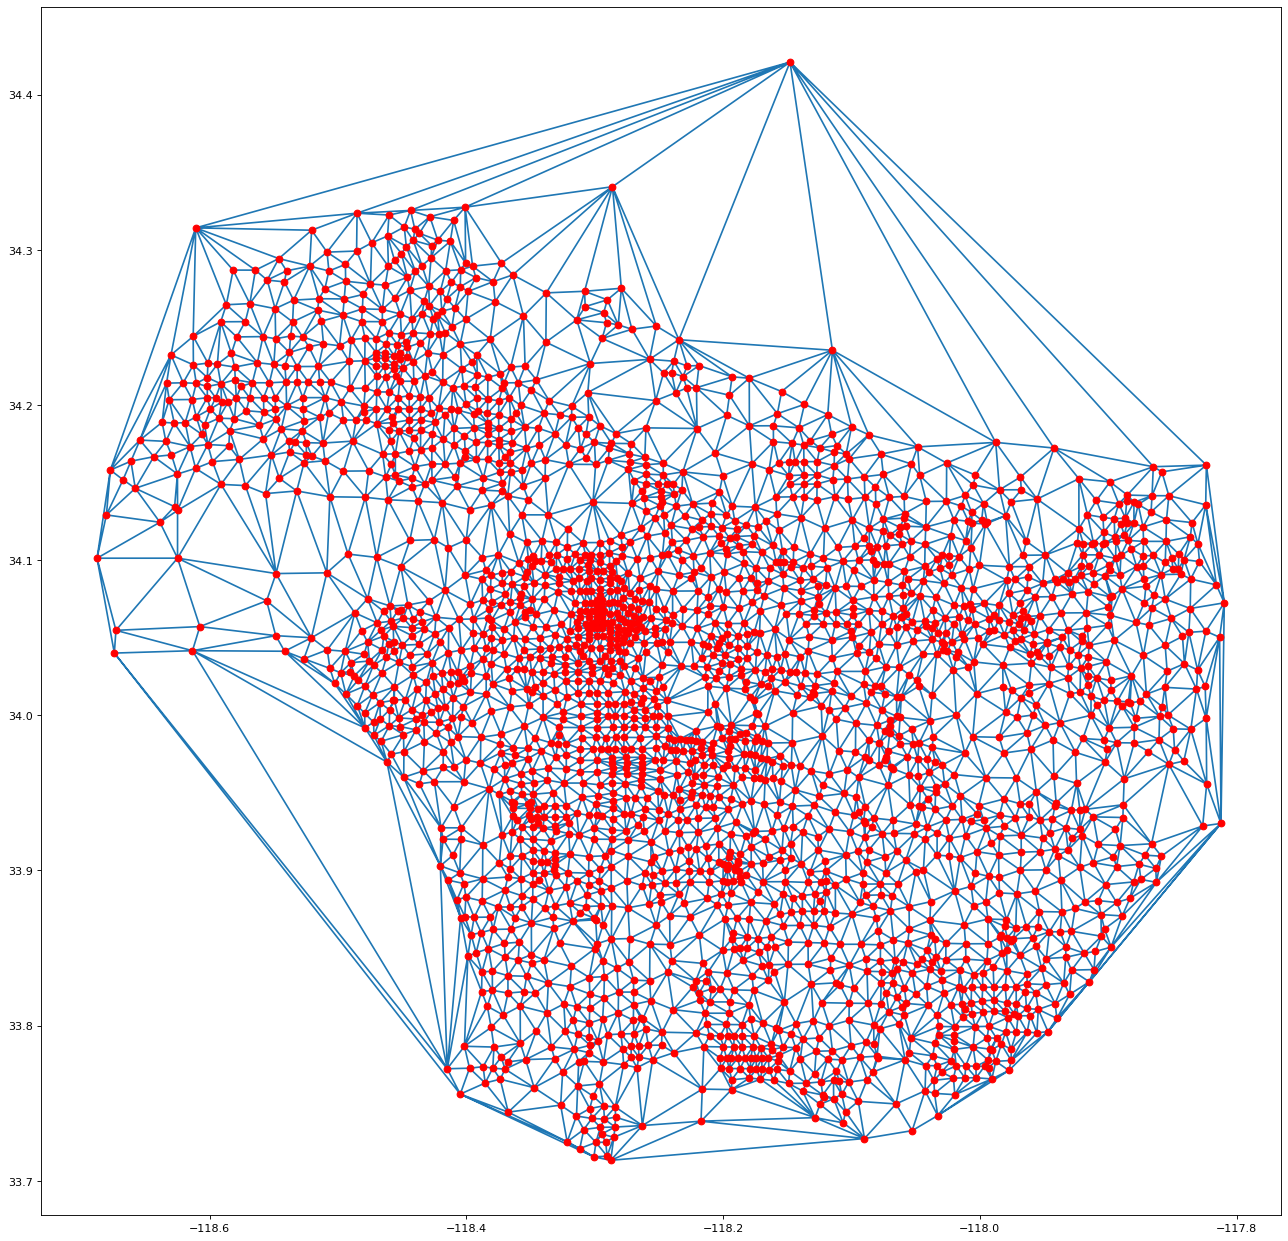

In [24]:
# am = nx.to_numpy_array(G0)

# print(am)
# nx.draw(Delaunay([x[1] for x in list(G0.nodes(data="centroid")) ]))
# plt.show()
sortedg = sorted(list(G0.nodes))
count = 0
idDict = {}
G0toGG = {}
for i in sortedg:
    idDict[count]=i
    G0toGG[i] = count
    count+=1
    
print(list(G0.nodes(data="centroid"))[2][1])
print(sorted(list(G0.nodes(data="centroid")))[2][1])
pointscord = [x[1] for x in sorted(list(G0.nodes(data="centroid")))]
tri = Delaunay(pointscord)
triangles = tri.simplices
pointsX = [x[0] for x in pointscord ]
pointsY = [x[1] for x in pointscord ]
figure(num=None, figsize=(20, 20), dpi=80, facecolor='w', edgecolor='b')
pyplot.plot(pointsX, pointsY,'ro')

pyplot.triplot(pointsX,pointsY,triangles)

# fig.set_size_inches(18.5, 10.5)
# pyplot.show()



In [25]:
print(G0.nodes[1030])
print(G0.nodes[1]['centroid'])


{'centroid': array([-118.37206185,   34.14943987])}
[-118.12180209   34.10124487]


# QUESTION 12:

In [26]:
GG = nx.Graph()
for i, cord in enumerate(zip(pointsX,pointsY)):

    
    GG.add_node(i ,pos=cord)


In [27]:
# print(tri.node)


# print(G0.nodes(data= True))


for path in triangles:
    nx.add_path(GG, path)
# a=0
# b=0
# print(len(g[2383]))
# print(len(g[1848]))
# print(idDict[1396])
for e in GG.edges:
#     print(e[0],e[1])
#     print(idDict[e[0]])
#     print(e[1])
#     print(idDict[e[1]])
    time = G0.get_edge_data(idDict[e[0]],idDict[e[1]])
#     GG[edge[0]][edge[1]]['weight']=
#     if time:
#         a+=1
#         print(time.get('mean_travel_time'))
    if not time:
#         b+=1
        x = nx.shortest_path(G0, source=idDict[e[0]], target=idDict[e[1]], weight ='mean_travel_time')
        time = 0
        for nodeid in range(len(x)):
            if nodeid+1 <len(x):
                time += g.get_edge_data(x[nodeid],x[nodeid+1])['mean_travel_time']
#         print(time)
#         print('error', e[0],e[1],time,x)
    else:
        time = time['mean_travel_time']
#     print(time)
    xy = G0.nodes[idDict[e[0]]]['centroid']
    x1 = xy[0]
    y1 = xy[1]
    xy1 = G0.nodes[idDict[e[1]]]['centroid']
    x2 = xy1[0]
    y2 = xy1[1]
    pythag_theorem = ((y1-y2)**2 + (x1-x2)**2)**(1/2)
    distance = pythag_theorem*69
    total =((3600/time)* distance/(distance/time*2 + 0.003))*2
    GG[e[0]][e[1]]['capacity'] = total
    GG[e[0]][e[1]]['time']= time
#     print(total)
#     print(GG.get_edge_data(e[0],e[1]))


# 3600/travel time = how many complete trips in an hours

# (d/t)*2 + 0.003 = car distance

# d/car distance = how many car on road at a time

# 3600/travel time* d/((d/t)*2+0.003)

# G[0][1]['weight']

In [28]:
print(4**(1/2))

2.0


# QUESTION 13:

In [29]:
nodeIDone = []
nodeIDtwo = []
for (p, d) in G0.nodes(data=True):
    if np.array_equal([round(i, 1 ) for i in d['centroid']], [ -118.5,34.0]):  
#         print(p,d)
        nodeIDone.append(p)
    elif np.array_equal([round(i, 2) for i in d['centroid']], [-118.18,33.77 ]):
        nodeIDtwo.append(p)


flow_value = nx.maximum_flow_value(GG, 1524, 660)
print("flow value: ", flow_value)
print("number of disjoint paths", len(list(nx.edge_disjoint_paths(GG, G0toGG[nodeIDone[0]],G0toGG[nodeIDtwo[0]]))))

 

# print(((G0.nodes[nodeID[0]]['centroid'][1] - G0.nodes[nodeID[1]]['centroid'][1])**2 + (G0.nodes[nodeID[0]]['centroid'][0]-G0.nodes[nodeID[1]]['centroid'][0])**2)**(1/2)*69)

flow value:  9156.944373828734
number of disjoint paths 6


In [30]:
print(np.array_equal([1,2],[1,2]))


True


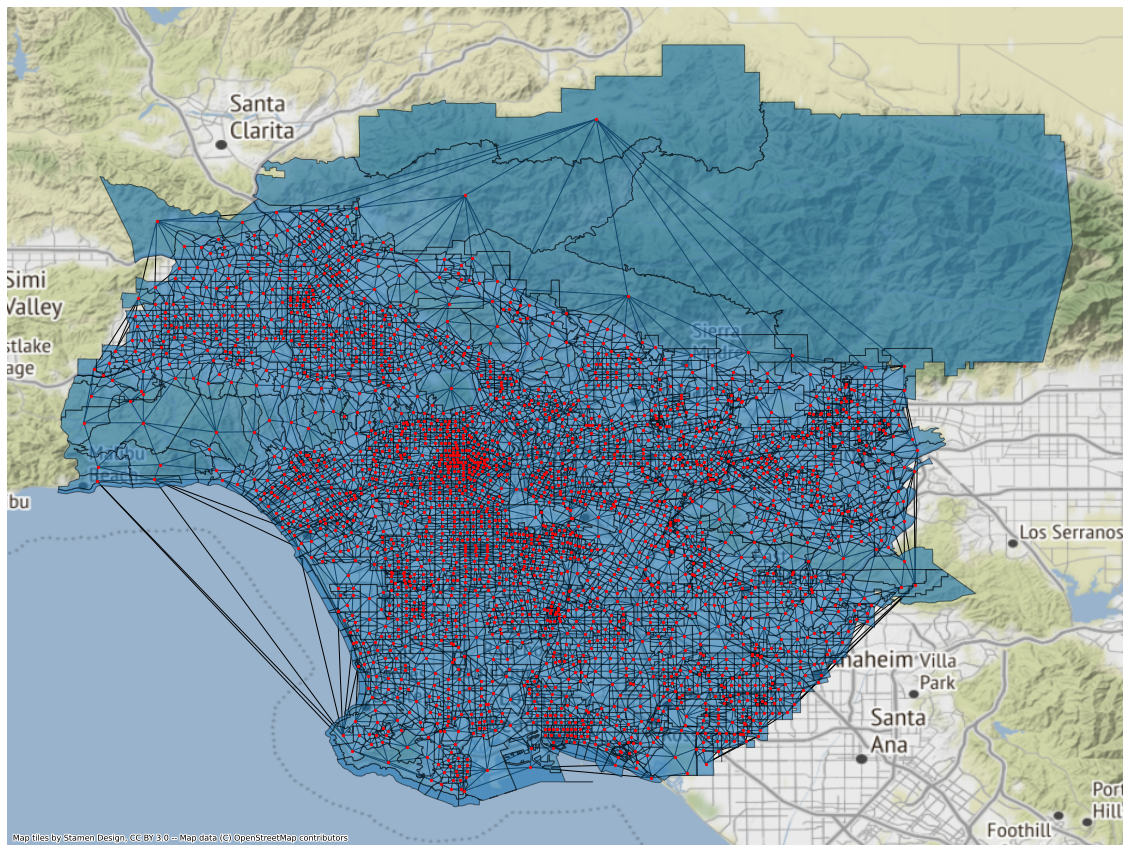

In [31]:
# qustion 14
fig, ax = pyplot.subplots(figsize=(20, 20))
# ax.set_aspect('equal')
pos = nx.get_node_attributes(GG,'pos')
nx.draw(GG, pos,ax = ax, node_size = 5, node_color ='r')

geo_df.plot(ax=ax,alpha=0.2)
# ax.triplot(pointsX,pointsY,triangles)
ax = geo_df.plot(ax = ax, alpha=0.5, edgecolor='k')
ctx.add_basemap(ax, crs=geo_df.crs.to_string())




In [33]:
# print(prunedG.edges(data=True))
# #run only once !
prunedG = nx.Graph.copy(GG)
count = 0
for e in prunedG.edges:
    time = prunedG[e[0]][e[1]]['time']
    if time > 60 * 15 and prunedG.has_edge(e[0],e[1]):
        prunedG.remove_edge(e[0],e[1])
        count += 1

print("removed ", count ," roads")
        
    
#         print(time)
#         print('error', e[0],e[1],time,x)

removed  48  roads


road with travel time more than 15 mins removed


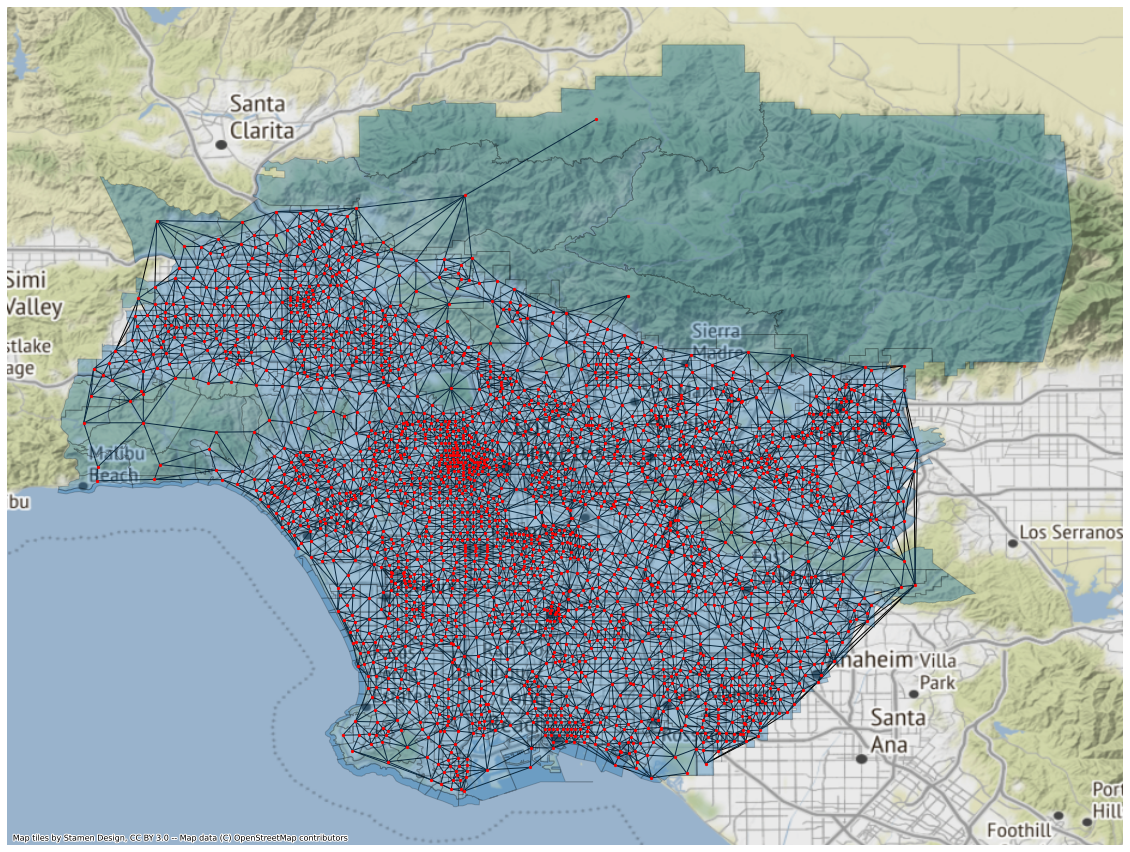

In [34]:
fig, ax = pyplot.subplots(figsize=(20, 20))
# ax.set_aspect('equal')
pos=nx.get_node_attributes(prunedG,'pos')
nx.draw(prunedG, pos,ax = ax, node_size = 5, node_color ='r')

geo_df.plot(ax=ax,alpha=0.2)
# ax.triplot(pointsX,pointsY,triangles)
ax = geo_df.plot(ax = ax, alpha = 0.2, edgecolor='k' )
ctx.add_basemap(ax, crs=geo_df.crs.to_string())
print("road with travel time more than 15 mins removed")


In [35]:
prunedG = nx.Graph.copy(GG)
count = 0
for e in prunedG.edges:
    time = prunedG[e[0]][e[1]]['time']
    if time > 60 * 20 and prunedG.has_edge(e[0],e[1]):
        prunedG.remove_edge(e[0],e[1])
        count += 1

print("removed ", count ," roads")
        
    
#         print(time)
#         print('error', e[0],e[1],time,x)

removed  25  roads


road with travel time more than 20 mins removed


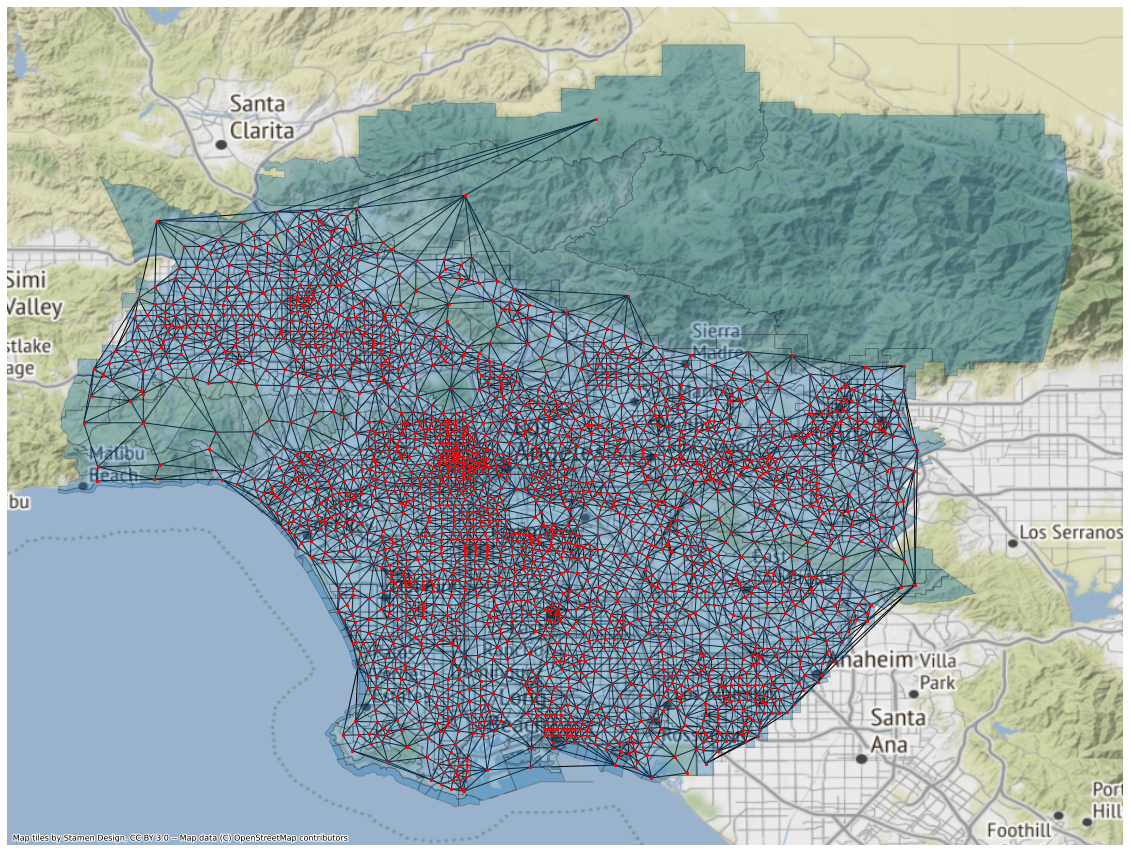

In [36]:
fig, ax = pyplot.subplots(figsize=(20, 20))
# ax.set_aspect('equal')
pos=nx.get_node_attributes(prunedG,'pos')
nx.draw(prunedG, pos,ax = ax, node_size = 5, node_color ='r')

geo_df.plot(ax=ax,alpha=0.2)
# ax.triplot(pointsX,pointsY,triangles)
ax = geo_df.plot(ax = ax, alpha = 0.2, edgecolor='k' )
ctx.add_basemap(ax, crs=geo_df.crs.to_string())
print("road with travel time more than 20 mins removed")


# QUESTION 15:

In [37]:
# fig, ax = pyplot.subplots(figsize=(20, 20))
# # ax.set_aspect('equal')
# pos=nx.get_node_attributes(GG,'pos')
# nx.draw(GG, pos,ax = ax, node_size = 20, node_color ='r')

# geo_df.plot(ax=ax,alpha=0.2)
# # ax.triplot(pointsX,pointsY,triangles)
# ax = geo_df.plot(ax = ax, alpha=0.5, edgecolor='k')
# ctx.add_basemap(ax, crs=geo_df.crs.to_string())

In [38]:
flow_value = nx.maximum_flow_value(prunedG, 1524, 660)


In [39]:
print("max care with pruned roads:", flow_value)

max care with pruned roads: 9156.944373828726
